In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# 📦 Imports
import pandas as pd
import numpy as np
import os
import sys
from pathlib import Path
from datetime import datetime
import pytz

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Add parent folder
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# 📚 Import utils
from src.utils import split_time_series_data

# 📂 Load final feature data
features_path = Path(r"C:\Users\MD\Desktop\citi\data\processed\final_features")

df_2024 = pd.read_parquet(features_path / "rides_citibike_final_2024_with_lags.parquet")

df = pd.concat([df_2024,]).reset_index(drop=True)

print(f"✅ Combined dataset shape: {df.shape}")

# ===============================
# ✂️ Correct Cutoff: Timezone-Aware
# ===============================

# Make cutoff timezone-aware
nyc_timezone = pytz.timezone("America/New_York")
cutoff_date = nyc_timezone.localize(datetime(2025, 1, 1, 0, 0, 0))

X_train, y_train, X_test, y_test = split_time_series_data(
    df,
    cutoff_date=cutoff_date,
    target_column="ride_count"
)

# ===============================
# 🛠️ Preprocessing for XGBoost
# ===============================

# Drop non-numeric columns
drop_cols = ["hour_ts", "start_station_name"]

X_train = X_train.drop(columns=drop_cols)
X_test = X_test.drop(columns=drop_cols)

# Encode categorical variable "time_of_day"
X_train = pd.get_dummies(X_train, columns=["time_of_day"], drop_first=True)
X_test = pd.get_dummies(X_test, columns=["time_of_day"], drop_first=True)

# ✅ Ensure columns match (sometimes necessary)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print(f"✅ Final X_train shape: {X_train.shape}")
print(f"✅ Final X_test shape: {X_test.shape}")

# ===============================
# ⚡ Train XGBoost Model
# ===============================

xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

print("🚀 Training XGBoost model...")
xgb_model.fit(X_train, y_train)

# 🔮 Predict
y_pred_xgb = xgb_model.predict(X_test)

# 📈 Evaluate
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"✅ XGBoost MAE: {mae_xgb:.2f}")
print(f"✅ XGBoost RMSE: {rmse_xgb:.2f}")


✅ Combined dataset shape: (43020, 687)
✅ Split complete: 39333 train samples, 3687 test samples
✅ Final X_train shape: (39333, 686)
✅ Final X_test shape: (3687, 686)
🚀 Training XGBoost model...
✅ XGBoost MAE: 3.42
✅ XGBoost RMSE: 4.93


C:\Users\MD\AppData\Local\Temp\ipykernel_15340\393885528.py:22: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MD\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


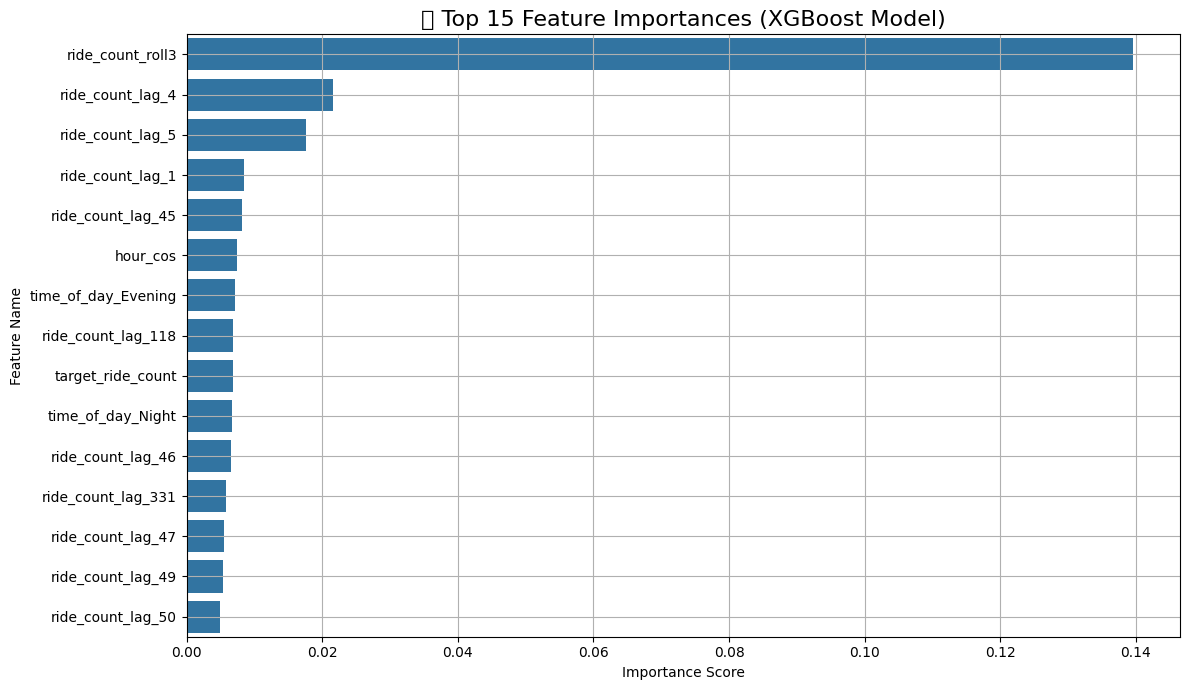

In [3]:
# ===============================
# 📈 Feature Importance (XGBoost)
# ===============================
import seaborn as sns
import matplotlib.pyplot as plt
importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(15))  # Top 15 features
plt.title("🚀 Top 15 Feature Importances (XGBoost Model)", fontsize=16)
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
import mlflow
import dagshub
from dotenv import load_dotenv

# 🛠 Load environment variables
load_dotenv()

# 🛠 Initialize DagsHub MLflow connection (ONLY ONCE per session)
dagshub.init(repo_owner="duddukuntamaneesh", repo_name="citi", mlflow=True)

# 🧠 Start MLflow run to log XGBoost metrics
with mlflow.start_run(run_name="XGBoostModel"):
    mlflow.log_metric("MAE", mae_xgb)
    mlflow.log_metric("RMSE", rmse_xgb)
    print("✅ XGBoost MAE and RMSE logged to DagsHub successfully!")


Accessing as duddukuntamaneesh

Initialized MLflow to track repo "duddukuntamaneesh/citi"

Repository duddukuntamaneesh/citi initialized!

✅ XGBoost MAE and RMSE logged to DagsHub successfully!
🏃 View run XGBoostModel at: https://dagshub.com/duddukuntamaneesh/citi.mlflow/#/experiments/0/runs/68b65b446e8f47c99f675c058f80c392
🧪 View experiment at: https://dagshub.com/duddukuntamaneesh/citi.mlflow/#/experiments/0
